In [1]:
#import MPO_hyperparameter_v2
#import MPO_tt_v2
#import MPO_inference_v2
import MPO_train_v2_LeNet5 as MPO

from neural_networks import *

# Pre-processing

## 1. Train

In [2]:
D = 8
threshold = 90

In [3]:
# List of layer 1 weights (0-3), layer 1 bias (4), layer 2 weights (5-8), layer 2 bias (9)
weights = MPO.main(r_1=D, r_2=D, r_3=D)

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.
Accuracy at step 0: 0.1091
Accuracy at step 1: 0.1092
Accuracy at step 2: 0.1106
Accuracy at step 3: 0.1112
Accuracy at step 4: 0.1113
Accuracy at step 5: 0.1115
Accuracy at step 6: 0.1124
Accuracy at step 7: 0.1127
Accuracy at step 8: 0.113
Accuracy at step 10: 0.1135
Accuracy at step 11: 0.1145
Accuracy at step 12: 0.1159
Accur

## 2. Open weights matrices into correct MPO

In [4]:
for weight in weights:
    print(weight.shape)

(5, 5, 1, 6)
(6,)
(5, 5, 6, 16)
(16,)
(16, 2)
(40, 80)
(48, 80)
(2, 16)
(120,)
(16, 2)
(24, 40)
(56, 48)
(2, 16)
(84,)
(8, 2)
(40, 24)
(16, 56)
(1, 16)
(10,)


In [5]:
def weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site):
    """ Used specifically to convert the weights output by the MPO-Net networks into their MPO form

    Args:
        weights: List of weights matrices including biases
        sigma: List of input physical dimensions
        sigma_prime: List of output physical dimensions
        layer: Layer number (indexed from 0) such that we start at the correct weights matrix

    Returns:
        MPO: List of tensors corresponding to MPO of layer
        bias: Vector corresponding to the bias found in the list of weights
    """
    # Reshape weights, order of indices are an assumption and may need to be modified
    MPO = []
    num_sites = len(sigma)
    #starting_site = layer*(num_sites+1)  # +1 to skip bias

    for i in range(num_sites):
        # sigma'*D_right, D_left*sigma
        if i == 0:
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, sigma[i]))
            # Need shape (D_right, sigma, sigma')
            site = np.transpose(site, (1, 2, 0))
        elif i != 0 and i != num_sites-1:
            # First D is right bond, Second D is left bond
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, D, sigma[i]))
            # Need shape (D_left, D_right, sigma, sigma')
            site = np.transpose(site, (2, 1, 3, 0))
        elif i == num_sites-1:
            # First D is right bond, Second D is left bond
            site = np.reshape(weights[i+starting_site], (sigma_prime[i], D, sigma[i]))
            # Need shape (D_left, sigma, sigma')
            site = np.transpose(site, (1, 2, 0))
        MPO.append(site)
    bias = weights[num_sites+starting_site]
    return MPO, bias

In [6]:
sigma = [2, 10, 10, 2]
sigma_prime = [2, 5, 6, 2]
MPO_0, bias_0 = weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site=4)

In [7]:
sigma = [2, 5, 6, 2]
sigma_prime = [2, 3, 7, 2]
MPO_1, bias_1 = weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site=9)

In [8]:
sigma = [2, 3, 7, 2]
sigma_prime = [1, 5, 2, 1]
MPO_2, bias_2 = weights_to_MPO_mod(weights, D, sigma, sigma_prime, starting_site=14)

In [9]:
#layers = [weights[0:3], layer2, layer3, layer4]

In [9]:
#inputs = np.random.rand(28, 28)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


# def weight_variable(shape):
#     weights = tf.Variable(tf.compat.v1.truncated_normal(shape, stddev=0.1))
#     return weights


# def bias_variable(shape):
# #     initial = tf.constant(0.0, shape=shape)
# #     return tf.Variable(initial)

# W_conv1 = weights[0]
# b_conv1 = weights[1]
# x_image = tf.reshape(inputs, [-1, 28, 28, 1])
# # 28x28x1
# h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
# # 28x28x6
# h_pool1 = max_pool_2x2(h_conv1)
# # 14x14x6
# W_conv2 = weights[2]
# b_conv2 = weights[3]
# h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# # 10x10x16
# h_pool2 = max_pool_2x2(h_conv2)
# # 5x5x16
# inputs = tf.reshape(h_pool2,[-1,400])
# inputs = inputs.eval(session=tf.compat.v1.Session()).shape

In [10]:
def LeNet5(MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2):
    """ Recreation of the FC2 network

    Args:
        MPO_0: List of tensors corresponding to MPO of 0th layer
        bias_0: Vector corresponding to bias of 0th layer
        MPO_1: List of tensors corresponding to MPO of 0th layer
        bias_1: Layer number (indexed from 0) such that we start at the correct weights matrix

    Returns:
        acc: Accuracy on test set
        t: Time to contract all layers
    """
    data = input_data.read_data_sets("./data/", validation_size=0, one_hot=True)

    start = time.time()


    for i in range(len(MPO_0)-1):
        if i == 0:
            layer_0 = con.contract_horizontal(MPO_0[i], MPO_0[i+1], 'right')
        else:
            layer_0 = con.contract_horizontal(layer_0, MPO_0[i+1], 'right')

    for i in range(len(MPO_1)-1):
        if i == 0:
            layer_1 = con.contract_horizontal(MPO_1[i], MPO_1[i+1], 'right')
        else:
            layer_1 = con.contract_horizontal(layer_1, MPO_1[i+1], 'right')

    for i in range(len(MPO_2)-1):
        if i == 0:
            layer_2 = con.contract_horizontal(MPO_2[i], MPO_2[i+1], 'right')
        else:
            layer_2 = con.contract_horizontal(layer_2, MPO_2[i+1], 'right')

    end = time.time()

    total = 100
    correct = 0
    for i in range(0, total):
        W_conv1 = weights[0]
        b_conv1 = weights[1]
        x_image = tf.reshape(data.test.images[i], [-1, 28, 28, 1])
        # 28x28x1
        h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
        # 28x28x6
        h_pool1 = max_pool_2x2(h_conv1)
        # 14x14x6
        W_conv2 = weights[2]
        b_conv2 = weights[3]
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        # 10x10x16
        h_pool2 = max_pool_2x2(h_conv2)
        # 5x5x16
        inputs = tf.reshape(h_pool2,[-1,400])
        out = inputs.eval(session=tf.compat.v1.Session())
        out = np.array(out)

        xW = act.ReLU(out @ layer_0 + bias_0)
        xW = act.ReLU(xW @ layer_1 + bias_1)
        result = xW @ layer_2 + bias_2
        index = result.argmax()
        if index == list(data.test.labels[i]).index(1):
            correct += 1

    acc = correct/total*100
    t = end-start
    return acc, t

In [11]:
acc, t = LeNet5(MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2)
print(acc)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
94.0


## 4. Close legs to use for compression algorithm

In [12]:
MPS_0 = close_legs(MPO_0)
MPS_1 = close_legs(MPO_1)
MPS_2 = close_legs(MPO_2)

## 5. Compress MPS layers

In [13]:
compressed_MPS_0, dist, sim = compress_layer(MPS_0, phys_dim=[4, 50, 60, 4], threshold=1e-8, plot=0)
compressed_MPS_0.append(MPS_0)
compressed_MPS_1, dist, sim = compress_layer(MPS_1, phys_dim=[4, 15, 42, 4], threshold=1e-8, plot=0)
compressed_MPS_1.append(MPS_1)
compressed_MPS_2, dist, sim = compress_layer(MPS_2, phys_dim=[2, 15, 14, 2], threshold=1e-8, plot=0)
compressed_MPS_2.append(MPS_2)

Sim: 14.132932965693263 Dist: 13.100108992238404 BondDim: 1
Sim: 55.222209423780384 Dist: 11.42469164356038 BondDim: 2
Sim: 90.1697084366522 Dist: 9.776301966365738 BondDim: 3
Sim: 121.92850891761066 Dist: 7.988571815825913 BondDim: 4
Sim: 141.208477867003 Dist: 6.673628001860449 BondDim: 5
Sim: 157.65149216893138 Dist: 5.300405305756109 BondDim: 6
Sim: 173.1345897001318 Dist: 3.5512249821839217 BondDim: 7
Sim: 13.3272344688847 Dist: 10.801937778444966 BondDim: 1
Sim: 48.428333874187544 Dist: 9.032206837982272 BondDim: 2
Sim: 80.2220085690898 Dist: 7.055996433473549 BondDim: 3
Sim: 99.13521029209124 Dist: 5.556427264545983 BondDim: 4
Sim: 110.70225833354432 Dist: 4.39395447231044 BondDim: 5
Sim: 120.50152624048687 Dist: 3.083434448434787 BondDim: 6
Sim: 125.98311903103536 Dist: 2.006483293537703 BondDim: 7
Sim: 23.248702427181573 Dist: 7.094713631518056 BondDim: 1
Sim: 50.077681775983876 Dist: 4.848296831305384 BondDim: 2
Sim: 60.98645744002951 Dist: 3.5492543583688327 BondDim: 3
Sim: 

In [14]:
print("Orig:", calculate_params(MPS_0))
for i in range(len(compressed_MPS_0)):
    print(i+1, round(calculate_params(compressed_MPS_0[i])/calculate_params(MPS_0)*100, 2), "% of Orig")

Orig: 7104
1 1.66 % of Orig
2 6.42 % of Orig
3 14.27 % of Orig
4 25.23 % of Orig
5 31.42 % of Orig
6 37.61 % of Orig
7 43.81 % of Orig
8 100.0 % of Orig


In [15]:
print("Orig:", calculate_params(MPS_1))
for i in range(len(compressed_MPS_1)):
    print(i+1, round(calculate_params(compressed_MPS_1[i])/calculate_params(MPS_1)*100, 2), "% of Orig")

Orig: 3712
1 1.75 % of Orig
2 6.57 % of Orig
3 14.47 % of Orig
4 25.43 % of Orig
5 31.57 % of Orig
6 37.72 % of Orig
7 43.86 % of Orig
8 100.0 % of Orig


In [16]:
print("Orig:", calculate_params(MPS_2))
for i in range(len(compressed_MPS_2)):
    print(i+1, round(calculate_params(compressed_MPS_2[i])/calculate_params(MPS_2)*100, 2), "% of Orig")

Orig: 1888
1 1.75 % of Orig
2 6.57 % of Orig
3 9.64 % of Orig
4 12.71 % of Orig
5 15.78 % of Orig
6 18.86 % of Orig
7 21.93 % of Orig
8 100.0 % of Orig


# Accuracy Tests

## 1. Check accuracy for each compressed dimension

In [33]:
def test_overall_accuracy_LeNet5(compressed_MPS_0, compressed_MPS_1, compressed_MPS_2, MPO_0_orig, bias_0, MPO_1_orig, bias_1, MPO_2_orig, bias_2, sigma_0, sigma_1, sigma_2, sigma_3):
    acc_compressed = []
    time_compressed = []
    params = []
    # if len(compressed_MPS_0) > len(compressed_MPS_1):
    #     shortest = len(compressed_MPS_1)
    #     longest = len(compressed_MPS_0)
    # else:
    #     shortest = len(compressed_MPS_0)
    #     longest = len(compressed_MPS_1)

    # for new_dim in range(1, longest+1):
    #     if new_dim < shortest:
    #         #MPS_0 = compressed_MPS_0[new_dim-1]
    #         MPS_1 = compressed_MPS_1[new_dim-1]
    #     else:
    #         if shortest == len(compressed_MPS_0):
    #             #MPS_0 = compressed_MPS_0[-1]
    #             MPS_1 = compressed_MPS_1[new_dim-1]
    #         elif shortest == len(compressed_MPS_1):
    #             #MPS_0 = compressed_MPS_0[new_dim-1]
    #             MPS_1 = compressed_MPS_1[-1]
    for new_dim in range(1, len(compressed_MPS_0)+1):
        MPS_0 = compressed_MPS_0[-1]
        MPS_1 = compressed_MPS_1[new_dim-1]
        MPS_2 = compressed_MPS_2[-1]
        dim_0 = [MPS_0[0].shape[1], MPS_0[1].shape[1], MPS_0[2].shape[1], MPS_0[3].shape[1]]
        dim_1 = [MPS_1[0].shape[1], MPS_1[1].shape[1], MPS_1[2].shape[1], MPS_1[3].shape[1]]
        dim_2 = [MPS_2[0].shape[1], MPS_2[1].shape[1], MPS_2[2].shape[1], MPS_2[3].shape[1]]
        MPO_0 = open_legs(MPS_0, sigma_0, sigma_1, bond_dim=dim_0)
        MPO_1 = open_legs(MPS_1, sigma_1, sigma_2, bond_dim=dim_1)
        MPO_2 = open_legs(MPS_2, sigma_2, sigma_3, bond_dim=dim_2)

        total_params = 0
        for tensor in MPO_0:
            total_params += tensor.size
        for tensor in MPO_1:
            total_params += tensor.size
        for tensor in MPO_2:
            total_params += tensor.size
        params.append(total_params)

        acc, t = LeNet5(MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2)
        acc_compressed.append(acc)
        time_compressed.append(t)

    params_orig = 0
    for tensor in MPO_0_orig:
        params_orig += tensor.size
    for tensor in MPO_1_orig:
        params_orig += tensor.size
    for tensor in MPO_2_orig:
        params_orig += tensor.size

    params = np.array(params)/params_orig*100
    acc_orig, time_orig = LeNet5(MPO_0_orig, bias_0, MPO_1_orig, bias_1, MPO_2_orig, bias_2)

    x = range(1, len(compressed_MPS_0)+1)
    data1 = acc
    data2 = params

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Compressed Dimension')
    ax1.set_ylabel('Accuracy [%]', color=color)
    ax1.plot(x, acc_compressed, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(acc_orig, color='r', linestyle='--')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Compression [%]', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, params, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_0)))

    fig.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(x, time_compressed)
    plt.title('Contraction Time vs. Compressed Dimension')
    plt.xlabel('Time [s]')
    plt.ylabel('Compressed Dimension')
    plt.axhline(time_orig, color='r', linestyle='--')

In [34]:
sigma_0 = [2, 10, 10, 2]
sigma_1 = [2, 5, 6, 2]
sigma_2 = [2, 3, 7, 2]
sigma_3 = [1, 5, 2, 1]
test_overall_accuracy_LeNet5(compressed_MPS_0, compressed_MPS_1, compressed_MPS_2, MPO_0, bias_0, MPO_1, bias_1, MPO_2, bias_2, sigma_0, sigma_1, sigma_2, sigma_3)

NameError: name 'new_' is not defined

In [23]:
i = -1
j = -2
dim_0 = [compressed_MPS_0[i][0].shape[1], compressed_MPS_0[i][1].shape[1], compressed_MPS_0[i][2].shape[1], compressed_MPS_0[i][3].shape[1]]
dim_1 = [compressed_MPS_1[i][0].shape[1], compressed_MPS_1[i][1].shape[1], compressed_MPS_1[i][2].shape[1], compressed_MPS_1[i][3].shape[1]]
dim_2 = [compressed_MPS_2[j][0].shape[1], compressed_MPS_2[j][1].shape[1], compressed_MPS_2[j][2].shape[1], compressed_MPS_2[j][3].shape[1]]
test_0 = open_legs(compressed_MPS_0[i], sigma_0, sigma_1, bond_dim=dim_0)
test_1 = open_legs(compressed_MPS_1[i], sigma_1, sigma_2, bond_dim=dim_1)
test_2 = open_legs(compressed_MPS_2[j], sigma_2, sigma_3, bond_dim=dim_2)

acc, t = LeNet5(test_0, bias_0, test_1, bias_1, test_2, bias_2)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [24]:
print(acc)

95.0


In [22]:
print(acc)

95.0


In [20]:
print(acc)

84.0


## 2. Check accuracy when compressing one layer at a time

In [22]:
def test_accuracy_single_layer(compressed_MPS_0, compressed_MPS_1, sigma, sigma_prime, layer):
    ### Check changes in W1 for constant W0
    plt.figure()
    for W0_dim in range(1, len(compressed_MPS_0)+1):
        acc_compressed = []
        time_compressed = []
        MPS_0_test = compressed_MPS_0[W0_dim-1]
        for W1_dim in range(1, len(compressed_MPS_1)+1):
            MPS_1_test = compressed_MPS_1[W1_dim-1]

            dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
            dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
            MPO_0_test = open_legs(MPS_0_test, MPO_0, bond_dim=dim_0)
            MPO_1_test = open_legs(MPS_1_test, MPO_1, bond_dim=dim_1)

            acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
            acc_compressed.append(acc)
            time_compressed.append(t)

        acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
        plt.plot(range(1, len(compressed_MPS_0)+1), acc_compressed, label="W0_dim=%d" % W0_dim)
        plt.axhline(threshold, color='r', linestyle='--')
        plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
        plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_0)+1))
        plt.xlabel('Compressed Dimension W1')
        plt.ylabel('Accuracy [%]')

mages-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
E

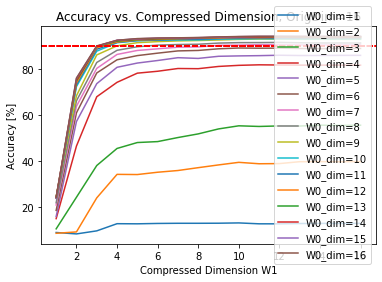

In [23]:
### Check changes in W1 for constant W0
plt.figure()
for W0_dim in range(1, len(compressed_MPS_0)+1):
    acc_compressed = []
    time_compressed = []
    MPS_0_test = compressed_MPS_0[W0_dim-1]
    for W1_dim in range(1, len(compressed_MPS_1)+1):
        MPS_1_test = compressed_MPS_1[W1_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=dim_1)

        acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
        #acc, t = FC2(MPS_0_test, bias_0, MPS_1_test, bias_1)
        acc_compressed.append(acc)
        time_compressed.append(t)

    acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
    plt.plot(range(1, len(compressed_MPS_0)+1), acc_compressed, label="W0_dim=%d" % W0_dim)
    plt.axhline(threshold, color='r', linestyle='--')
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
    plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_0)))
    plt.xlabel('Compressed Dimension W1')
    plt.ylabel('Accuracy [%]')

mages-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
E

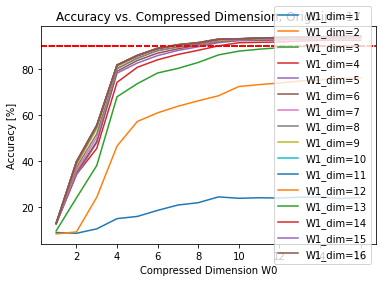

In [24]:
### Check changes in W0 for constant W1
plt.figure()
for W1_dim in range(1, len(compressed_MPS_1)+1):
    acc_compressed = []
    time_compressed = []
    MPS_1_test = compressed_MPS_1[W1_dim-1]
    for W0_dim in range(1, len(compressed_MPS_0)+1):
        MPS_0_test = compressed_MPS_0[W0_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=dim_1)

        acc, t = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
        acc_compressed.append(acc)
        time_compressed.append(t)


    acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
    plt.plot(range(1, len(compressed_MPS_0)+1), acc_compressed, label="W1_dim=%d" % W1_dim)
    plt.legend(loc='center right', bbox_to_anchor=(1, 0.5))
    plt.axhline(threshold, color='r', linestyle='--')
    plt.title('Accuracy vs. Compressed Dimension, OrigDim=%d' %(len(compressed_MPS_1)+1))
    plt.xlabel('Compressed Dimension W0')
    plt.ylabel('Accuracy [%]')

## 3. Heatmap of accuracy by layer dimension

In [14]:
acc_orig, time_orig = FC2(MPO_0, bias_0, MPO_1, bias_1)
acc_matrix = []
for W0_dim in range(1, len(compressed_MPS_0)+1):
    acc_array = []
    MPS_0_test = compressed_MPS_0[W0_dim-1]
    for W1_dim in range(1, len(compressed_MPS_1)+1):
        MPS_1_test = compressed_MPS_1[W1_dim-1]

        dim_0 = [MPS_0_test[0].shape[1], MPS_0_test[1].shape[1], MPS_0_test[2].shape[1], MPS_0_test[3].shape[1]]
        dim_1 = [MPS_1_test[0].shape[1], MPS_1_test[1].shape[1], MPS_1_test[2].shape[1], MPS_1_test[3].shape[1]]
        MPO_0_test = open_legs(MPS_0_test, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=dim_0)
        MPO_1_test = open_legs(MPS_1_test, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=dim_1)


        acc, _ = FC2(MPO_0_test, bias_0, MPO_1_test, bias_1)
        acc_array.append(acc)
    acc_matrix.append(acc_array)

mages-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
E

Text(0.5, 1.0, 'Accuracy vs. Compressed Dimensions, OrigDim=16')

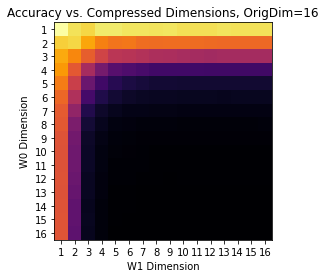

In [24]:
### Plotting
fig, ax = plt.subplots()
im = ax.imshow(acc_matrix, cmap='inferno_r')

# We want to show all ticks...
ax.set_xticks(np.arange(len(compressed_MPS_0)))
ax.set_yticks(np.arange(len(compressed_MPS_1)))
# ... and label them with the respective list entries
ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

plt.xlabel('W1 Dimension')
plt.ylabel('W0 Dimension')
plt.title('Accuracy vs. Compressed Dimensions, OrigDim=%d' % D)
# Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(acc_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

## 4. Compression ratio for layer dimensions

In [25]:
orig_params = calculate_params(MPS_0)+calculate_params(MPS_1)
params_matrix = []
compression_ratio_matrix = []
for i in range(len(compressed_MPS_0)):
    compression_ratio = []
    for j in range(len(compressed_MPS_1)):
        params = calculate_params(compressed_MPS_0[i]) + calculate_params(compressed_MPS_1[j])
        compression_ratio.append(round(params/orig_params*100, 2))
    compression_ratio_matrix.append(compression_ratio)

Text(0.5, 1.0, 'Compression Ratio vs. Compressed Dimensions, OrigDim=16')

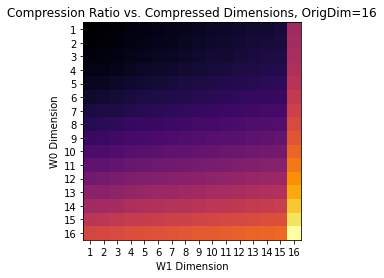

In [28]:
### Plotting
fig, ax = plt.subplots()
im = ax.imshow(compression_ratio_matrix, cmap='inferno')

ax.set_xticks(np.arange(len(compressed_MPS_0)))
ax.set_yticks(np.arange(len(compressed_MPS_1)))
ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

plt.xlabel('W1 Dimension')
plt.ylabel('W0 Dimension')
plt.title('Compression Ratio vs. Compressed Dimensions, OrigDim=%d' % D)

# Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(compression_ratio_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

## 5. Compression ratio for accuracy above threshold 

Best Compression: 15.46 %
W0_dim =  7
W1_dim =  6


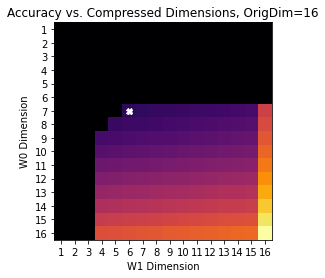

In [30]:
compression_ratio_plot = np.array(compression_ratio_matrix[:])
acc_matrix_plot = np.array(acc_matrix[:])
compression_ratio_plot[acc_matrix_plot < threshold] = 0

fig, ax = plt.subplots()
im = ax.imshow(compression_ratio_plot, cmap='inferno')
ax.set_xticks(np.arange(len(compressed_MPS_0)))
ax.set_yticks(np.arange(len(compressed_MPS_1)))
ax.set_xticklabels(np.arange(1, len(compressed_MPS_0)+1))
ax.set_yticklabels(np.arange(1, len(compressed_MPS_1)+1))

plt.xlabel('W1 Dimension')
plt.ylabel('W0 Dimension')
plt.title('Accuracy vs. Compressed Dimensions, OrigDim=%d' % D)
try:
    minval = np.min(compression_ratio_plot[np.nonzero(compression_ratio_plot)])
    ij = np.where(compression_ratio_plot == minval)
    plt.plot(ij[1], ij[0], 'wX')
    print("Best Compression:", minval, "%")
    print("W0_dim = ", ij[0][0]+1)
    print("W1_dim = ", ij[1][0]+1)
except:
    print("Layers cannot be compressed and still reach given threshold")


# Loop over data dimensions and create text annotations.
# for i in range(len(compressed_MPS_0)):
#     for j in range(len(compressed_MPS_1)):
#         text = ax.text(j, i, np.round(compression_ratio_matrix[i][j], 2),
#                        ha="center", va="center", color="w")

## 6. Dependence of accuracy on compression

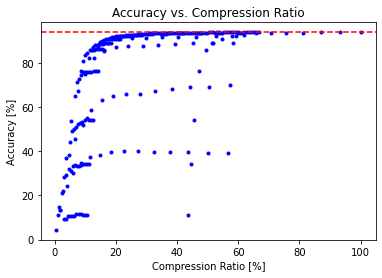

In [31]:
sorted_comp = np.array(compression_ratio_matrix[:])
sorted_acc = np.array(acc_matrix[:])
sorted_comp = np.reshape(sorted_comp, sorted_comp.size)
sorted_acc = np.reshape(sorted_acc, sorted_acc.size)
sorted_comp, sorted_acc = zip(*sorted(zip(sorted_comp, sorted_acc)))

plt.plot(sorted_comp, sorted_acc, 'b.')

plt.title("Accuracy vs. Compression Ratio")
plt.xlabel("Compression Ratio [%]")
plt.ylabel("Accuracy [%]")
plt.axhline(acc_orig, color='r', linestyle='--')

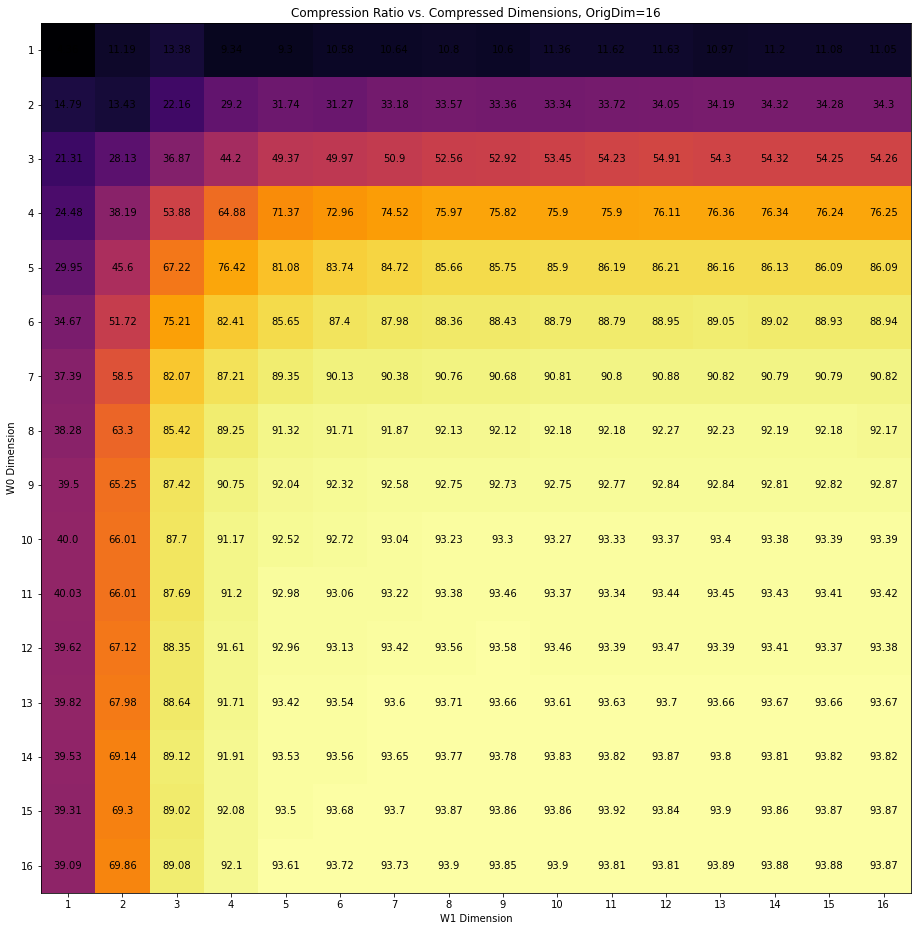

In [33]:
### Plotting
plt.figure(figsize = (16,16))
plt.imshow(acc_matrix_plot, cmap='inferno')

plt.xticks(np.arange(len(compressed_MPS_0)), labels=np.arange(1, len(compressed_MPS_0)+1))
plt.yticks(np.arange(len(compressed_MPS_1)), labels=np.arange(1, len(compressed_MPS_1)+1))
plt.xlabel(np.arange(1, len(compressed_MPS_0)+1))
plt.ylabel(np.arange(1, len(compressed_MPS_1)+1))

plt.xlabel('W1 Dimension')
plt.ylabel('W0 Dimension')
plt.title('Compression Ratio vs. Compressed Dimensions, OrigDim=%d' % D)

# Loop over data dimensions and create text annotations.
for i in range(len(compressed_MPS_0)):
    for j in range(len(compressed_MPS_1)):
        text = plt.text(j, i, np.round(acc_matrix_plot[i][j], 2),
                       ha="center", va="center", color="k")

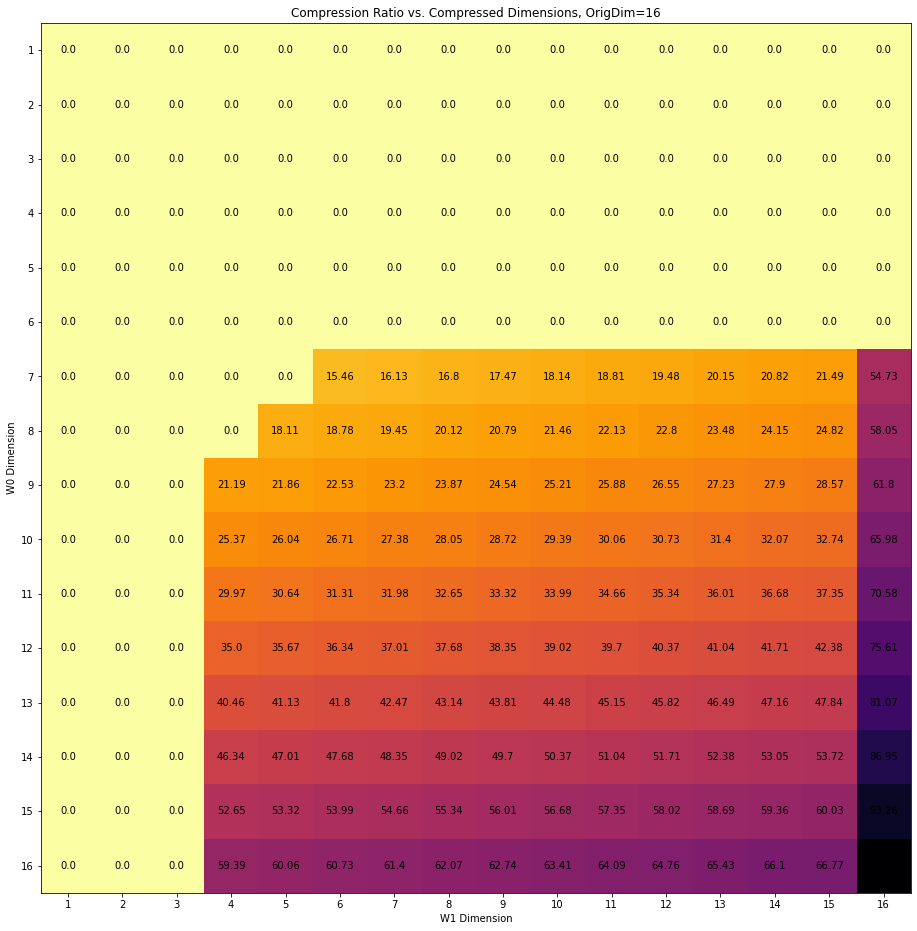

In [37]:
### Plotting
plt.figure(figsize = (16,16))
plt.imshow(compression_ratio_plot, cmap='inferno_r')

plt.xticks(np.arange(len(compressed_MPS_0)), labels=np.arange(1, len(compressed_MPS_0)+1))
plt.yticks(np.arange(len(compressed_MPS_1)), labels=np.arange(1, len(compressed_MPS_1)+1))
plt.xlabel(np.arange(1, len(compressed_MPS_0)+1))
plt.ylabel(np.arange(1, len(compressed_MPS_1)+1))

plt.xlabel('W1 Dimension')
plt.ylabel('W0 Dimension')
plt.title('Compression Ratio vs. Compressed Dimensions, OrigDim=%d' % D)

# Loop over data dimensions and create text annotations.
for i in range(len(compressed_MPS_0)):
    for j in range(len(compressed_MPS_1)):
        text = plt.text(j, i, np.round(compression_ratio_plot[i][j], 2),
                       ha="center", va="center", color="k")

In [38]:
def compress_layer_single_dim(raw_state, phys_dim, threshold, compressed_dim, compressed_state=0, plot=0):
    """ Initializes a compressed state then sweeps left->right
        and right->left until a minimum is reached
        i.e. the difference in our metrics between sweeps is less than a
        specified threshold up to the bond dimension of the raw state

        Note: Does NOT normalize the state unlike the compression function
              found in compression.py

    Args:
        raw_state: MPS to be compressed
        phys_dim: List of physical dimensions by site
        threshold: Difference between sweeps under which a solution is found
        compressed_state: Initial starting state if necessary
                          otherwise a random MPS is ini
        plot: Whether or not to plot the compression values (0 off, 1 on)

    Returns:
        compressions: Final compressed state at each bond dimension
        best_dist: List of overlap values for each bond dimension
        best_sim: List of cosine similarity values for each bond dimension
    """
    compressed_state = init.initialize_random_MPS_with_changing_phys_dim(phys_dim,
                                                                         num_sites=len(raw_state),
                                                                         bond_dim=compressed_dim)
    bond_dim_raw_state = raw_state[math.ceil(len(raw_state)/2)].shape[0]

    # Initialize accuracy metrics
    dist = []  # Frobenius norm
    sim = []   # Cosine similarity (Scalar product)
    dist.append(metrics.overlap(compressed_state, raw_state))
    sim.append(metrics.scalar_product(compressed_state, raw_state))
    # We sweep left to right and then back right to left across the mixed state
    while True:
        # Left->right sweep
        for site in range(0, len(raw_state)-1):
            compressed_state[site], compressed_state[site+1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='right')
        # Right->left sweep
        for site in range(len(raw_state)-1, 0, -1):
            compressed_state[site], compressed_state[site-1] = comp.update_site(compressed_state, raw_state,
                                                                           site=site, dir='left')

        # Metrics taken after each sweep
        dist.append(metrics.overlap(compressed_state, raw_state))
        sim.append(metrics.scalar_product(compressed_state, raw_state))
        # Check if sweeps are still working
        if np.abs(dist[-2]-dist[-1]) < threshold:
            # Normalize to maintain length and update metrics
            #compressed_state, _ = can.left_normalize(compressed_state)
            #best_dist.append((metrics.overlap(compressed_state, raw_state)))
            #best_sim.append(metrics.scalar_product(compressed_state, raw_state))
            if plot == 0:
                print("Sim:", sim[-1], "Dist:", dist[-1], "BondDim:", compressed_dim)
            #compressions.append(compressed_state[:])
            break

    return compressed_state, dist, sim


In [40]:
### Optimized path
# 1. Starting state
# 2. Compress all layers down by 1
# 3. Calculate delta_params in all directions
# 4. Calculate delta_acc in all directions
# 5. Moved based on minimizing delta_acc/delta_params

sigma = [4, 7, 7, 4]
sigma_prime = [4, 4, 4, 4]
MPO_0, bias_0 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=0)

sigma = [4, 4, 4, 4]
sigma_prime = [1, 10, 1, 1]
MPO_1, bias_1 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=1)

layers = [MPO_0, MPO_1]

acc, _ = FC2(MPO_0, bias_0, MPO_1, bias_1)
threshold = 90
last_updated = np.ones(len(layers))
while True:
    print(acc)
    # 1. Starting state
    MPS_0 = close_legs(layers[0])
    MPS_1 = close_legs(layers[1])

    # 2. Compress all layers down by 1
    dim0 = MPS_0[math.ceil(len(MPS_0)/2)].shape[0]
    dim1 = MPS_1[math.ceil(len(MPS_1)/2)].shape[0]
    
    if last_updated[0] == 1:
        compressed_0, _, _ = compress_layer_single_dim(MPS_0, phys_dim=[16,28,28,16], threshold=1e-6, compressed_dim=dim0-1)
        bonds0 = [compressed_0[0].shape[1], compressed_0[1].shape[1], compressed_0[2].shape[1], compressed_0[3].shape[1]]
        new_MPO_0 = open_legs(compressed_0, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=bonds0)
    if last_updated[1] == 1:
        compressed_1, _, _ = compress_layer_single_dim(MPS_1, phys_dim=[4,40,4,4], threshold=1e-6, compressed_dim=dim1-1)
        bonds1 = [compressed_1[0].shape[1], compressed_1[1].shape[1], compressed_1[2].shape[1], compressed_1[3].shape[1]]
        new_MPO_1 = open_legs(compressed_1, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=bonds1)
    MPOs = [new_MPO_0, new_MPO_1]

    # 3. Calculate delta_params
    delta_params0 = calculate_params(MPO_0) - calculate_params(new_MPO_0)
    delta_params1 = calculate_params(MPO_1) - calculate_params(new_MPO_1)

    # 4. Calculate delta_acc
    new_acc0, _ = FC2(new_MPO_0, bias_0, layers[1], bias_1)
    new_acc1, _ = FC2(layers[0], bias_0, new_MPO_1, bias_1)
    new_acc = [new_acc0, new_acc1]
    delta_acc0 = acc - new_acc0
    delta_acc1 = acc - new_acc1

    # 5. Calculate slope
    slope = [delta_acc0/delta_params0, delta_acc1/delta_params1]

    # 6. Find minimum slope
    index = np.argmin(slope)

    # 7. Update layers
    if new_acc0 < threshold and new_acc1 < threshold:
        break
    else:
        layers[index] = MPOs[index]
        acc = new_acc[index]
        last_updated = np.zeros(len(layers))
        last_updated[index] = 1
        print(last_updated)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
93.87
Sim: 1648.6333154931197 Dist: 4.035923881491458 BondDim: 15
Sim: 67.30286212973505 Dist: 0.015442027150739054 BondDim: 15
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
[0. 1.]
93.88
Sim: 67.30015369213167 Dist: 0.05204265177197835 BondDim: 14
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyt

In [53]:
ij

(array([6], dtype=int64), array([5], dtype=int64))

In [54]:
### Params compared to trained MPO model
orig_params = calculate_params(MPO_0) + calculate_params(MPO_1)
params = calculate_params(compressed_MPS_0[6]) + calculate_params(compressed_MPS_1[5])
print(round(params/orig_params*100, 2), "%")

params = calculate_params(layers[0]) + calculate_params(layers[1])
print(round(params/orig_params*100, 2), "%")

15.46 %
18.11 %


In [55]:
### Params compared to typical model
orig_params = 768*256 + 256*10
params = calculate_params(compressed_MPS_0[6]) + calculate_params(compressed_MPS_1[8])
print(round(params/orig_params*100, 2), "%")

params = calculate_params(layers[0]) + calculate_params(layers[1])
print(round(params/orig_params*100, 2), "%")

2.3 %
2.39 %


In [65]:
### Permutations
# 1. Starting state
# 2. Compress single layer down until threshold
# 3. Switch layers

sigma = [4, 7, 7, 4]
sigma_prime = [4, 4, 4, 4]
MPO_0, bias_0 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=0)

sigma = [4, 4, 4, 4]
sigma_prime = [1, 10, 1, 1]
MPO_1, bias_1 = weights_to_MPO(weights, D, sigma, sigma_prime, layer=1)

layers = [MPO_0, MPO_1]

acc, _ = FC2(MPO_0, bias_0, MPO_1, bias_1)
threshold = 90
last_updated = np.ones(len(layers))

print(acc)
# 1. Starting state
MPS_0 = close_legs(layers[0])
MPS_1 = close_legs(layers[1])

# 2. Compress single layer down until acc less than threshold
dim0 = MPS_0[math.ceil(len(MPS_0)/2)].shape[0]
dim1 = MPS_1[math.ceil(len(MPS_1)/2)].shape[0]

layer_to_compress = 1
for i in range(len(layers)):
    if layer_to_compress == 0:
        while True:
            compressed_0, _, _ = compress_layer_single_dim(MPS_0, phys_dim=[16,28,28,16], threshold=1e-6, compressed_dim=dim0-1)
            bonds0 = [compressed_0[0].shape[1], compressed_0[1].shape[1], compressed_0[2].shape[1], compressed_0[3].shape[1]]
            new_MPO = open_legs(compressed_0, sigma=[4,7,7,4], sigma_prime=[4,4,4,4], bond_dim=bonds0)
            new_acc, _ = FC2(new_MPO, bias_0, layers[1], bias_1)
            print(new_acc)
            if new_acc < threshold:
                layer_to_compress = 1
                break
            else:
                layers[layer_to_compress] = new_MPO
                dim0 = dim0-1

    elif layer_to_compress == 1:
        while True:
            compressed_1, _, _ = compress_layer_single_dim(MPS_1, phys_dim=[4,40,4,4], threshold=1e-6, compressed_dim=dim1-1)
            bonds1 = [compressed_1[0].shape[1], compressed_1[1].shape[1], compressed_1[2].shape[1], compressed_1[3].shape[1]]
            new_MPO = open_legs(compressed_1, sigma=[4,4,4,4], sigma_prime=[1,10,1,1], bond_dim=bonds1)
            new_acc, _ = FC2(layers[0], bias_0, new_MPO, bias_1)
            print(new_acc)
            if new_acc < threshold:
                layer_to_compress = 0
                break
            else:
                layers[layer_to_compress] = new_MPO
                dim1 = dim1-1

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
93.87
Sim: 67.30286212970482 Dist: 0.015442028131288114 BondDim: 15
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
93.88
Sim: 67.30015369167334 Dist: 0.05428530431116446 BondDim: 14
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
93.88
Sim: 67.27090425430686 Dist: 0.1794333626465372 BondDim: 13
Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
93.89
Sim: 67.20787210415153 Dist: 0.3085911239585396 BondDim: 12
Extracting ./data/tra

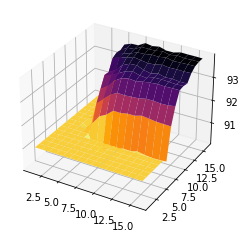

In [94]:
trimmed_acc = acc_matrix_plot[:]
trimmed_acc[acc_matrix_plot <= threshold] = threshold+1

fig = plt.figure()
ax = plt.gca(projection='3d')
x, y = np.meshgrid(np.arange(1,len(trimmed_acc)+1), np.arange(1,len(trimmed_acc[0])+1))
ax.plot_surface(x, y, trimmed_acc, cmap='inferno_r')

In [93]:
acc_matrix_plot

array([[90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ,
        90.  , 90.  , 90.  , 90.  , 90.  , 90.  , 90.  ],
       [90.  , 90.  , 90.  , 90.  , 90.  , 90.13, 90.38, 90.76, 90.68,
        90.81, 90.8 , 90.88, 90.82, 90.79, 90.79, 90.82],
       [90.  , 90.  , 90.  , 90.  , 91.32, 91.71, 91.87, 92.13, 92.12,
        92.18, 92.18, 92.2